In [2]:

import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import root

In [3]:
"""
%% Summary of CJK_Func.m %%
The function generates the value of CJK representation. 
Note that, this function is not used directly, it is used to solve for Bt
--------------------------------------------------------------------------
Input:
    Bt - the value of boundary at t
    Bs - the value of boundary at s
    k - strike price
    r - risk-free interest rate
    q - continuously compounded dividend rate
    vol - annualized volatility
    T - maturity
    t - current time
--------------------------------------------------------------------------
Output:
   y - value of CJK reprentation
--------------------------------------------------------------------------
Author:
    Nattapong Kongmuang
    nat.kmg@gmail.com
    MSc Financial Engineering, ICMA Centre, Henley Business School, 
    University of Reading, UK
    24 July 2015
--------------------------------------------------------------------------
"""

def d1(x,y,z,b,vol):
   return (np.log(x/y)+(b+0.5*vol**2)*z)/(vol*np.sqrt(z)) 

def d2(x,y,z,b,vol):
    return d1(x,y,z,b,vol)-vol*np.sqrt(z) 

def CJK_Func( Bt,Bs,k,r,q,vol,T,t ):
    
    T1 = T-t
    b=r-q
    term = np.zeros(5)
    term[0] = Bt
    term[1] = -k
    term[2] = k*np.exp(-r*T1)*norm.cdf(-d2(Bt,k,T1,b,vol))
    term[3] = -Bt*np.exp(-q*T1)*norm.cdf(-d1(Bt,k,T1,b,vol))
    integralFun = lambda s: r*k*np.exp(-r*(s))*norm.cdf(-d2(Bt,Bs,(s),b,vol)) - q*Bt*np.exp(-q*(s))*norm.cdf(-d1(Bt,Bs,(s),b,vol))
    term[4] = quad(integralFun,t,T)[0]
    y = np.sum(term)
    return y


In [4]:
"""
%% Summary of Boundary.m %%
The function generates the early exercise boundary and spot of time by 
CJK representation
--------------------------------------------------------------------------
Input:
    k - strike price
    r - risk-free interest rate
    q - continuously compounded dividend rate
    vol - annualized volatility
    T - time to maturity
    steps - a number of time steps in the calculation
--------------------------------------------------------------------------
Output:
    B - the values of early exercise boundary 
    time - the point of time that each B-value is calculated
--------------------------------------------------------------------------
Author:
    Nattapong Kongmuang
    nat.kmg@gmail.com
    MSc Financial Engineering, ICMA Centre, Henley Business School, 
    University of Reading, UK
    24 July 2015
--------------------------------------------------------------------------
"""
def Boundary( k,r,q,vol,T,steps ):
    dt=T/steps
    t=T
    B = np.zeros(steps+1)
    time = np.linspace(0,T,np.floor(dt).astype(np.int))
    for i  in range(steps,1,-1):
        if i==steps:
            if q == 0:
                B[i]=np.min(k,k*r/q)
            else:
                B[i]=k
        else:
            t=t-dt
            res=root(lambda Bt: CJK_Func(Bt,B[i+1],k,r,q,vol,T,t) ,k)
            B[i] = res.x
            
    return B

In [10]:
s0 = 100
k = 100
r = 0.07
q = 0.03
vol = 0.25
T=1
#paths = 100000
steps = 10000
dt=T/steps
   
B = Boundary( k,r,q,vol,T,steps) 

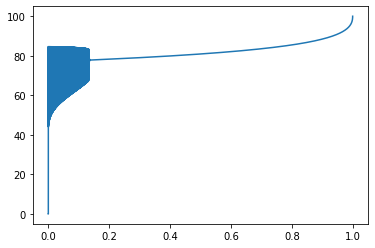

In [11]:
from matplotlib import pyplot as plt
plt.plot(np.linspace(0,1,10001),B)

In [12]:
from scipy.stats.distributions import norm, lognorm, rv_frozen
class GeometricBrownianMotion:
    '''Geometric Brownian Motion.(with optional drift).'''
    def __init__(self, mu: float=0.0, sigma: float=1.0):
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) \
            -> np.array:
        assert t.ndim == 1, 'One dimensional time vector required'
        assert t.size > 0, 'At least one time point is required'
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), 'Increasing time vector required'
        # transposed simulation for automatic broadcasting
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)
        return np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T

    def distribution(self, t: float) -> rv_frozen:
        mu_t = (self.mu - self.sigma**2/2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)

In [13]:
from scipy.optimize import newton
class LS:
    def __init__(self, X, t, r, strike):
        self.X = X
        self.t = t
        self.r = r
        self.strike = strike

    def _ls_american_option_quadratic_iter(self, X, t, r, strike):
        # given no prior exercise we just receive the payoff of a European option
        cashflow = np.maximum(strike - X[-1, :], 0.0)
        # iterating backwards in time
        for i in reversed(range(1, X.shape[1] - 1)):
            # discount factor between t[i] and t[i+1]
            df = np.exp(-r * (t[i+1]-t[i]))
            # discount cashflows from next period
            cashflow = cashflow * df
            x = X[:, i]
            # exercise value for time t[i]
            exercise = np.maximum(strike - x, 0.0)
            # boolean index of all in-the-money paths
            itm = exercise > 0
            # fit polynomial of degree 2
            fitted = Polynomial.fit(x[itm], cashflow[itm], 2)
            # approximate continuation value
            continuation = fitted(x)
            # boolean index where exercise is beneficial
            ex_idx = itm & (exercise > continuation)
            # update cashflows with early exercises
            cashflow[ex_idx] = exercise[ex_idx]

        func = cashflow - strike
        res = newton(func,strike)
        yield res,cashflow, x, fitted, continuation, exercise, ex_idx

    def simulate(self):
        for res,cashflow, *_ in self._ls_american_option_quadratic_iter(self.X, self.t, self.r, self.strike):
            pass
        return res,cashflow.mean(axis=0) * np.exp(-self.r * (self.t[1] - self.t[0]))